# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

#FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [01:55<00:00, 518File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

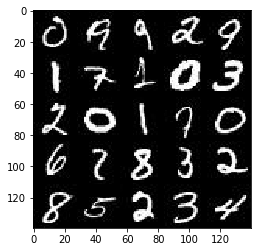

In [1]:

import helper
data_dir = './data'
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

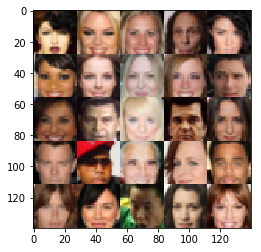

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32)
    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 1.0
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x?
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
                              #kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
        # 14x14x64
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 7x7x128
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 1.0
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 14x14x128 now

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob=keep_prob)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.0
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                 labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                       labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #from IPython.core.debugger import Tracer; Tracer()()
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    #from IPython.core.debugger import Tracer; Tracer()()

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    losses = []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1515... Generator Loss: 11.3579
Epoch 1/2... Discriminator Loss: 0.0560... Generator Loss: 4.5517
Epoch 1/2... Discriminator Loss: 0.7007... Generator Loss: 14.6466
Epoch 1/2... Discriminator Loss: 6.2822... Generator Loss: 0.0070
Epoch 1/2... Discriminator Loss: 1.7418... Generator Loss: 0.5478
Epoch 1/2... Discriminator Loss: 3.7850... Generator Loss: 10.0892
Epoch 1/2... Discriminator Loss: 1.0448... Generator Loss: 0.7630
Epoch 1/2... Discriminator Loss: 0.4829... Generator Loss: 9.4587
Epoch 1/2... Discriminator Loss: 0.1984... Generator Loss: 3.0391
Epoch 1/2... Discriminator Loss: 0.4585... Generator Loss: 1.4878


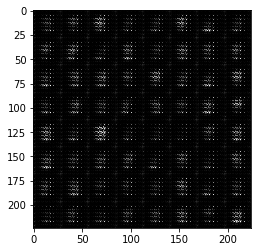

Epoch 1/2... Discriminator Loss: 0.1534... Generator Loss: 2.6396
Epoch 1/2... Discriminator Loss: 0.1724... Generator Loss: 2.4954
Epoch 1/2... Discriminator Loss: 0.1064... Generator Loss: 2.7620
Epoch 1/2... Discriminator Loss: 0.2684... Generator Loss: 1.9319
Epoch 1/2... Discriminator Loss: 0.3507... Generator Loss: 3.1275
Epoch 1/2... Discriminator Loss: 1.0225... Generator Loss: 1.7958
Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 1.7767
Epoch 1/2... Discriminator Loss: 0.6536... Generator Loss: 1.3634
Epoch 1/2... Discriminator Loss: 0.4488... Generator Loss: 2.5686
Epoch 1/2... Discriminator Loss: 0.7083... Generator Loss: 2.2448


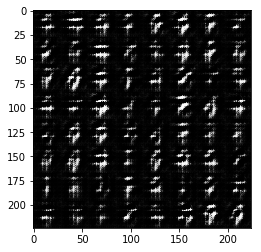

Epoch 1/2... Discriminator Loss: 0.5029... Generator Loss: 1.9888
Epoch 1/2... Discriminator Loss: 0.5543... Generator Loss: 1.5126
Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 1.9950
Epoch 1/2... Discriminator Loss: 1.2338... Generator Loss: 0.7623
Epoch 1/2... Discriminator Loss: 0.8148... Generator Loss: 2.4421
Epoch 1/2... Discriminator Loss: 0.6646... Generator Loss: 1.6781
Epoch 1/2... Discriminator Loss: 0.7697... Generator Loss: 1.0664
Epoch 1/2... Discriminator Loss: 0.7154... Generator Loss: 1.3916
Epoch 1/2... Discriminator Loss: 0.5508... Generator Loss: 2.6040
Epoch 1/2... Discriminator Loss: 0.8640... Generator Loss: 1.1161


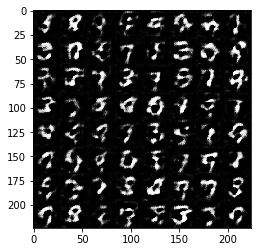

Epoch 1/2... Discriminator Loss: 0.6819... Generator Loss: 1.4681
Epoch 1/2... Discriminator Loss: 1.7175... Generator Loss: 0.2895
Epoch 1/2... Discriminator Loss: 0.9387... Generator Loss: 1.7767
Epoch 1/2... Discriminator Loss: 1.5046... Generator Loss: 0.4283
Epoch 1/2... Discriminator Loss: 0.8665... Generator Loss: 1.1087
Epoch 1/2... Discriminator Loss: 0.7546... Generator Loss: 1.3402
Epoch 1/2... Discriminator Loss: 1.0127... Generator Loss: 0.7907
Epoch 1/2... Discriminator Loss: 0.7959... Generator Loss: 1.1049
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 2.7164
Epoch 1/2... Discriminator Loss: 1.1368... Generator Loss: 0.6725


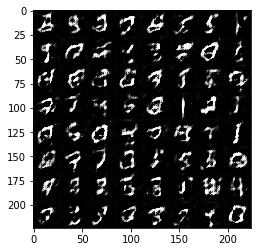

Epoch 1/2... Discriminator Loss: 0.9087... Generator Loss: 1.4131
Epoch 1/2... Discriminator Loss: 1.2352... Generator Loss: 1.6345
Epoch 1/2... Discriminator Loss: 0.8523... Generator Loss: 1.2807
Epoch 1/2... Discriminator Loss: 1.2671... Generator Loss: 0.4560
Epoch 1/2... Discriminator Loss: 1.0297... Generator Loss: 0.6014
Epoch 1/2... Discriminator Loss: 0.8674... Generator Loss: 1.7082
Epoch 1/2... Discriminator Loss: 1.4446... Generator Loss: 2.4206
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 1.1587
Epoch 1/2... Discriminator Loss: 0.9224... Generator Loss: 1.1503
Epoch 1/2... Discriminator Loss: 1.0801... Generator Loss: 0.7008


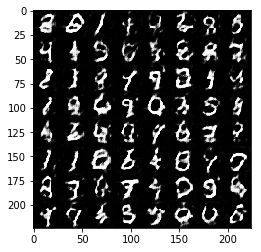

Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 1.2551
Epoch 1/2... Discriminator Loss: 0.9500... Generator Loss: 1.3320
Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 1.9939
Epoch 1/2... Discriminator Loss: 0.9182... Generator Loss: 0.8636
Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 1.0340... Generator Loss: 1.3311
Epoch 1/2... Discriminator Loss: 0.8848... Generator Loss: 0.9854
Epoch 1/2... Discriminator Loss: 1.1172... Generator Loss: 1.8877
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.6408
Epoch 1/2... Discriminator Loss: 1.1233... Generator Loss: 1.6844


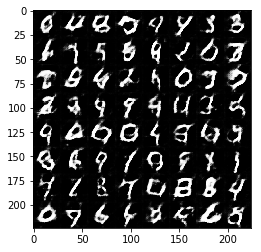

Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 0.6907
Epoch 1/2... Discriminator Loss: 1.0551... Generator Loss: 1.4629
Epoch 1/2... Discriminator Loss: 0.8166... Generator Loss: 1.1959
Epoch 1/2... Discriminator Loss: 1.3250... Generator Loss: 0.4535
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 1.0738
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 0.9613
Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 1.7505
Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 1.5758
Epoch 1/2... Discriminator Loss: 1.0725... Generator Loss: 0.6176
Epoch 1/2... Discriminator Loss: 0.8929... Generator Loss: 0.8331


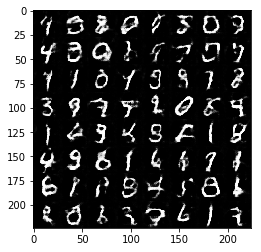

Epoch 1/2... Discriminator Loss: 0.9135... Generator Loss: 1.0119
Epoch 1/2... Discriminator Loss: 1.3140... Generator Loss: 0.4613
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 1.9546
Epoch 1/2... Discriminator Loss: 1.1377... Generator Loss: 1.3333
Epoch 1/2... Discriminator Loss: 0.8332... Generator Loss: 1.2771
Epoch 1/2... Discriminator Loss: 1.8157... Generator Loss: 0.2494
Epoch 1/2... Discriminator Loss: 1.0533... Generator Loss: 0.8799
Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 0.7407
Epoch 1/2... Discriminator Loss: 0.8522... Generator Loss: 0.9211
Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 0.9447


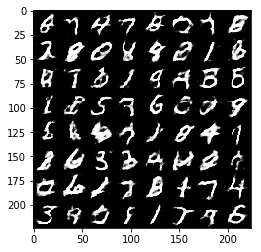

Epoch 1/2... Discriminator Loss: 0.9292... Generator Loss: 0.8868
Epoch 1/2... Discriminator Loss: 0.8617... Generator Loss: 1.1389
Epoch 1/2... Discriminator Loss: 0.8708... Generator Loss: 1.6399
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 0.8128
Epoch 1/2... Discriminator Loss: 2.5417... Generator Loss: 0.1248
Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 0.6663
Epoch 1/2... Discriminator Loss: 0.9282... Generator Loss: 1.1778
Epoch 1/2... Discriminator Loss: 0.8626... Generator Loss: 1.0021
Epoch 1/2... Discriminator Loss: 0.8297... Generator Loss: 1.2666
Epoch 1/2... Discriminator Loss: 0.9804... Generator Loss: 0.7450


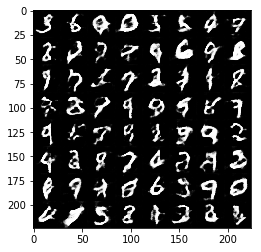

Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 2.2933
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 0.7408
Epoch 1/2... Discriminator Loss: 1.0596... Generator Loss: 0.6341
Epoch 2/2... Discriminator Loss: 0.9888... Generator Loss: 0.8925
Epoch 2/2... Discriminator Loss: 1.0194... Generator Loss: 0.8168
Epoch 2/2... Discriminator Loss: 1.1731... Generator Loss: 0.5247
Epoch 2/2... Discriminator Loss: 1.8191... Generator Loss: 3.2343
Epoch 2/2... Discriminator Loss: 1.0204... Generator Loss: 0.7667
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 0.9000
Epoch 2/2... Discriminator Loss: 0.9701... Generator Loss: 0.9220


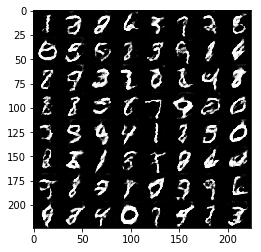

Epoch 2/2... Discriminator Loss: 2.3391... Generator Loss: 3.0702
Epoch 2/2... Discriminator Loss: 1.0730... Generator Loss: 1.0251
Epoch 2/2... Discriminator Loss: 0.9700... Generator Loss: 1.0367
Epoch 2/2... Discriminator Loss: 0.9397... Generator Loss: 1.0616
Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 0.3755
Epoch 2/2... Discriminator Loss: 1.1127... Generator Loss: 0.6656
Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 1.4336
Epoch 2/2... Discriminator Loss: 1.4576... Generator Loss: 1.9408
Epoch 2/2... Discriminator Loss: 0.9226... Generator Loss: 0.9720
Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 0.9357


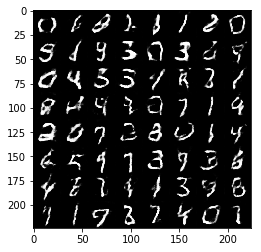

Epoch 2/2... Discriminator Loss: 0.8392... Generator Loss: 0.8764
Epoch 2/2... Discriminator Loss: 1.8624... Generator Loss: 0.2518
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 0.7278
Epoch 2/2... Discriminator Loss: 0.9942... Generator Loss: 0.8158
Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 1.0099
Epoch 2/2... Discriminator Loss: 1.0422... Generator Loss: 1.3488
Epoch 2/2... Discriminator Loss: 0.9787... Generator Loss: 0.8792
Epoch 2/2... Discriminator Loss: 1.1973... Generator Loss: 0.4917
Epoch 2/2... Discriminator Loss: 0.9290... Generator Loss: 0.7654
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 0.5455


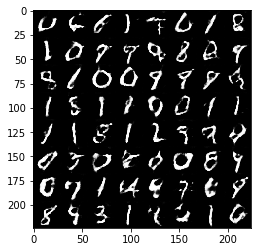

Epoch 2/2... Discriminator Loss: 1.1018... Generator Loss: 1.8146
Epoch 2/2... Discriminator Loss: 1.0414... Generator Loss: 1.0087
Epoch 2/2... Discriminator Loss: 1.1169... Generator Loss: 0.6628
Epoch 2/2... Discriminator Loss: 1.0129... Generator Loss: 0.6405
Epoch 2/2... Discriminator Loss: 0.8337... Generator Loss: 0.8931
Epoch 2/2... Discriminator Loss: 1.3627... Generator Loss: 1.5396
Epoch 2/2... Discriminator Loss: 0.8891... Generator Loss: 0.9738
Epoch 2/2... Discriminator Loss: 0.8051... Generator Loss: 0.8659
Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 1.1409
Epoch 2/2... Discriminator Loss: 0.7887... Generator Loss: 1.1470


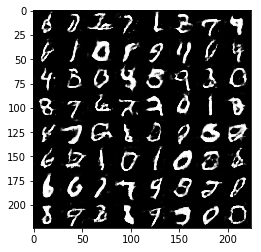

Epoch 2/2... Discriminator Loss: 1.2259... Generator Loss: 0.5237
Epoch 2/2... Discriminator Loss: 1.1646... Generator Loss: 0.6802
Epoch 2/2... Discriminator Loss: 1.2160... Generator Loss: 0.5750
Epoch 2/2... Discriminator Loss: 1.1316... Generator Loss: 0.7233
Epoch 2/2... Discriminator Loss: 0.8606... Generator Loss: 1.1474
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 0.9520
Epoch 2/2... Discriminator Loss: 1.1047... Generator Loss: 1.3805
Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 1.1910
Epoch 2/2... Discriminator Loss: 1.0347... Generator Loss: 0.7396
Epoch 2/2... Discriminator Loss: 0.9149... Generator Loss: 1.0285


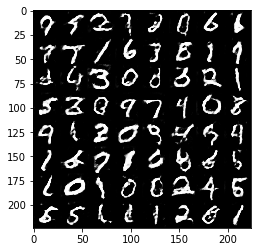

Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 0.7510
Epoch 2/2... Discriminator Loss: 1.2834... Generator Loss: 0.6073
Epoch 2/2... Discriminator Loss: 0.9628... Generator Loss: 0.7922
Epoch 2/2... Discriminator Loss: 1.0307... Generator Loss: 0.7989
Epoch 2/2... Discriminator Loss: 0.7764... Generator Loss: 0.9770
Epoch 2/2... Discriminator Loss: 0.8424... Generator Loss: 0.9297
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 0.8051
Epoch 2/2... Discriminator Loss: 1.0407... Generator Loss: 0.7721
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 0.7288
Epoch 2/2... Discriminator Loss: 0.8501... Generator Loss: 1.3574


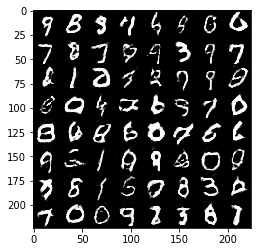

Epoch 2/2... Discriminator Loss: 1.0639... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 0.9795... Generator Loss: 0.7329
Epoch 2/2... Discriminator Loss: 0.8890... Generator Loss: 1.0564
Epoch 2/2... Discriminator Loss: 0.9068... Generator Loss: 1.7904
Epoch 2/2... Discriminator Loss: 0.8321... Generator Loss: 1.2686
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 2.0273
Epoch 2/2... Discriminator Loss: 1.1462... Generator Loss: 1.5672
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 1.2170
Epoch 2/2... Discriminator Loss: 0.8375... Generator Loss: 1.2359
Epoch 2/2... Discriminator Loss: 0.7081... Generator Loss: 1.0306


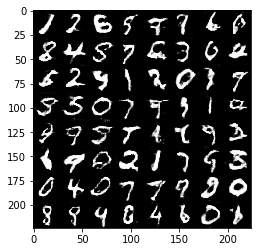

Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 0.4552
Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 1.0941
Epoch 2/2... Discriminator Loss: 0.8474... Generator Loss: 2.0220
Epoch 2/2... Discriminator Loss: 1.0491... Generator Loss: 2.1539
Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 0.4855
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 1.4004
Epoch 2/2... Discriminator Loss: 1.0142... Generator Loss: 0.6402
Epoch 2/2... Discriminator Loss: 0.9065... Generator Loss: 1.2795
Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 1.2935
Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 0.8027


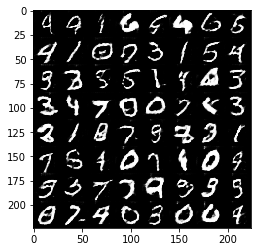

Epoch 2/2... Discriminator Loss: 1.4209... Generator Loss: 0.3753
Epoch 2/2... Discriminator Loss: 0.7202... Generator Loss: 1.2611
Epoch 2/2... Discriminator Loss: 1.1371... Generator Loss: 0.5515
Epoch 2/2... Discriminator Loss: 0.9890... Generator Loss: 0.9675
Epoch 2/2... Discriminator Loss: 0.8829... Generator Loss: 1.0680
Epoch 2/2... Discriminator Loss: 0.9274... Generator Loss: 1.2168
Epoch 2/2... Discriminator Loss: 1.1349... Generator Loss: 0.7038
Epoch 2/2... Discriminator Loss: 0.8763... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 1.3402... Generator Loss: 0.4452
Epoch 2/2... Discriminator Loss: 0.9719... Generator Loss: 0.7413


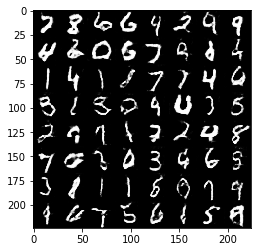

Epoch 2/2... Discriminator Loss: 1.1946... Generator Loss: 2.1327
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.5156
Epoch 2/2... Discriminator Loss: 1.0176... Generator Loss: 0.6974
Epoch 2/2... Discriminator Loss: 2.0239... Generator Loss: 0.1853
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 0.9891
Epoch 2/2... Discriminator Loss: 0.6518... Generator Loss: 1.2500
Epoch 2/2... Discriminator Loss: 1.5147... Generator Loss: 0.3508


IndexError: list index out of range

In [11]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
#from IPython.core.debugger import Tracer; Tracer()()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.7260... Generator Loss: 0.0105
Epoch 1/1... Discriminator Loss: 1.9675... Generator Loss: 0.1711
Epoch 1/1... Discriminator Loss: 0.1653... Generator Loss: 9.0289
Epoch 1/1... Discriminator Loss: 0.1246... Generator Loss: 7.3889
Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 10.4359
Epoch 1/1... Discriminator Loss: 0.2125... Generator Loss: 4.8735
Epoch 1/1... Discriminator Loss: 0.5760... Generator Loss: 4.7037
Epoch 1/1... Discriminator Loss: 0.5059... Generator Loss: 2.0160
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 1.0769


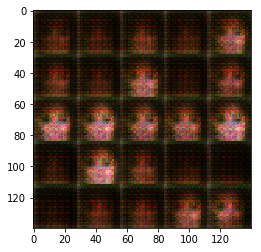

Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 0.4831... Generator Loss: 2.9418
Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 2.9089
Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 3.5577
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.3606
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 1.6124
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 1.2147
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.8039


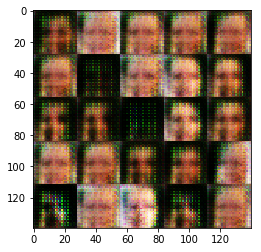

Epoch 1/1... Discriminator Loss: 0.6248... Generator Loss: 2.0476
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 1.2245
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 1.5796
Epoch 1/1... Discriminator Loss: 1.8952... Generator Loss: 1.4719
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.1548
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.6734
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.4177
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 0.9756


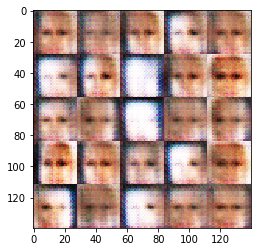

Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.4801
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 1.8225
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 1.6268
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 2.1593... Generator Loss: 0.1947
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 1.5362


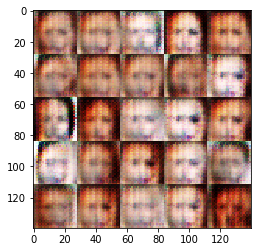

Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.2064
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 0.7272... Generator Loss: 1.3229
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.7228
Epoch 1/1... Discriminator Loss: 1.6671... Generator Loss: 2.8013
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.4231
Epoch 1/1... Discriminator Loss: 0.4106... Generator Loss: 2.5085


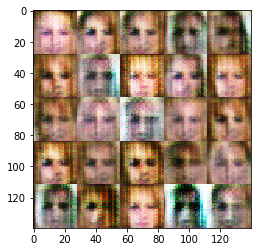

Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.7874
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 2.0277... Generator Loss: 0.3419
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.7545
Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 1.6019
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.4466


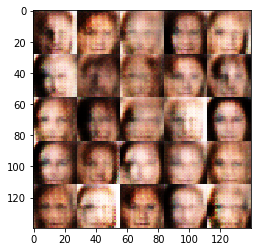

Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 1.6279... Generator Loss: 0.4254
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 1.4213
Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 0.7637... Generator Loss: 1.6083


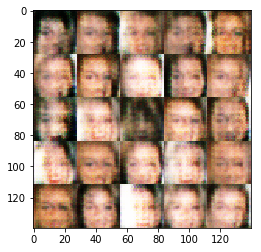

Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.2723
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.5406
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 1.2858
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.2674
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.5708


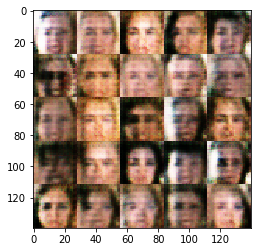

Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.7233
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 1.6550
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 2.1831


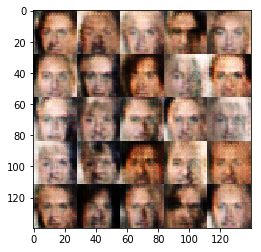

Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 1.3388
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.4864
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.1130


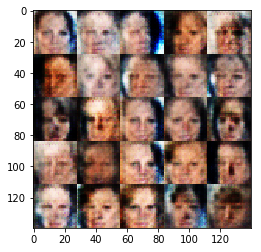

Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 1.6168
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 0.8714... Generator Loss: 1.5547
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 1.0286


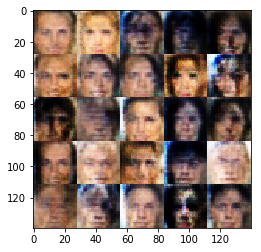

Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 1.1259
Epoch 1/1... Discriminator Loss: 1.6860... Generator Loss: 0.4426
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 1.6324
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.6671
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.6612


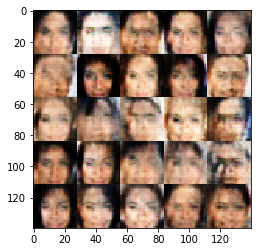

Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.4040
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 1.1623
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 1.1802


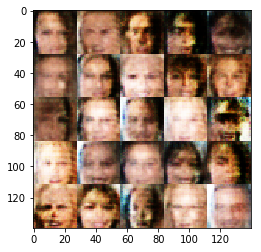

Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.3342
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.3803
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 0.8734


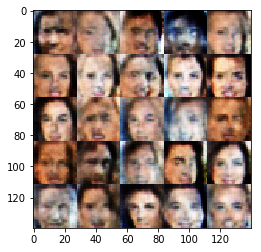

Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.6463
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.6434
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.3596


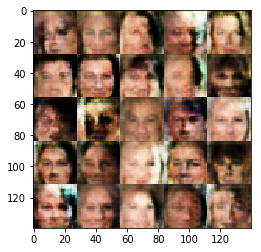

Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 1.9564
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.3875
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.1967
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 1.3360
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.4225
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.2532


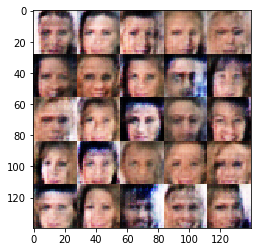

Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.4052
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.6995


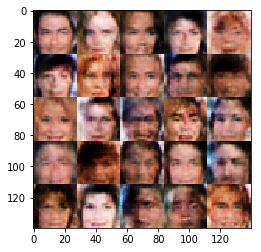

Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.9545
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 2.0733
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.5694
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.2028


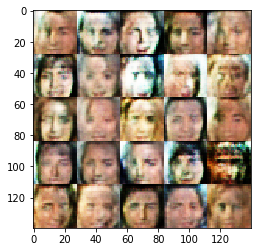

Epoch 1/1... Discriminator Loss: 1.5767... Generator Loss: 0.3781
Epoch 1/1... Discriminator Loss: 2.2747... Generator Loss: 0.1497
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.4432
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.4202
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 1.3970
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.3373


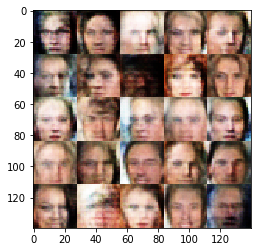

Epoch 1/1... Discriminator Loss: 1.6236... Generator Loss: 0.3911
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.7243
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 1.1437
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 1.3864
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.4866


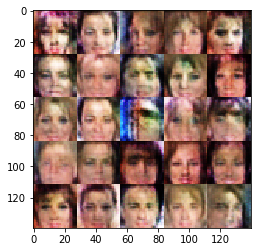

Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 2.0655
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.4770
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.5933
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 1.2086


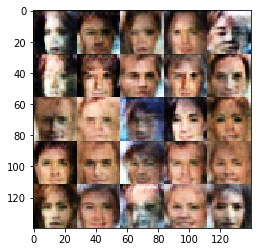

Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.3620
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.1356
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.3690


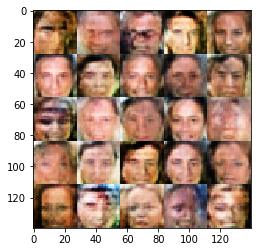

Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 1.9600
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 0.8562... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.3077
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.6632


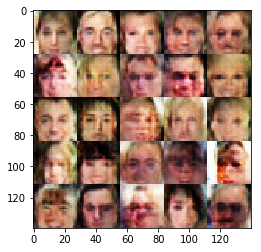

Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 0.6600... Generator Loss: 1.5833
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 1.0506
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.4386
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 2.1180
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 1.4270
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 1.4825


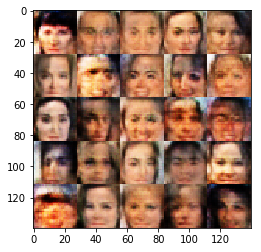

Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.1486
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.4221
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.5436... Generator Loss: 0.3360
Epoch 1/1... Discriminator Loss: 0.9006... Generator Loss: 1.1412
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.3403
Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 1.6324


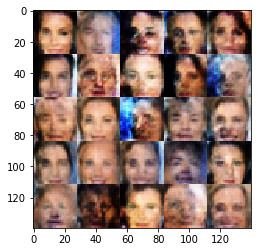

Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.9035... Generator Loss: 0.2177
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 1.4438
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.7299


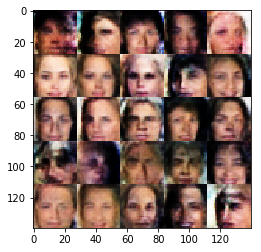

Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 1.6755
Epoch 1/1... Discriminator Loss: 1.6903... Generator Loss: 0.2838
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 1.4782
Epoch 1/1... Discriminator Loss: 1.6288... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.8081
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.4099
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 1.9747
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 0.7941


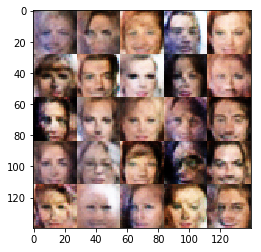

Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 1.1205
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.2841
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 2.2468
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 1.1439
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.5201
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 1.4111
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 0.6586


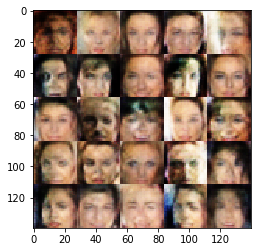

Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.3672
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.5491... Generator Loss: 0.3365
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.7653... Generator Loss: 0.2514
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.4479


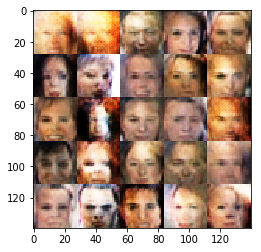

Epoch 1/1... Discriminator Loss: 0.9218... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 1.3267
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 2.1543
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 1.2776
Epoch 1/1... Discriminator Loss: 0.5703... Generator Loss: 1.7223
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.8520


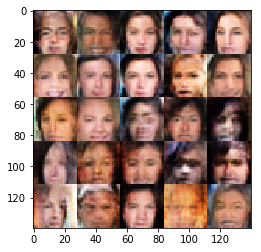

Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.7329
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 1.8378
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.9714


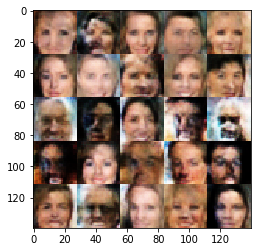

Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 1.1553
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.7790


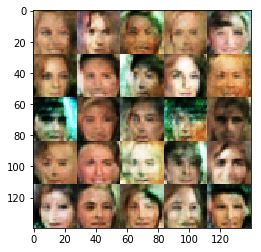

Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 0.3861
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 2.2976
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.6243... Generator Loss: 0.3238
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.7113... Generator Loss: 2.8137
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 1.1707
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.5785


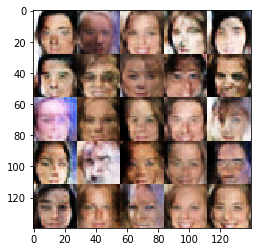

Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.2594
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 1.6218
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.0284
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 1.1958
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 2.1377


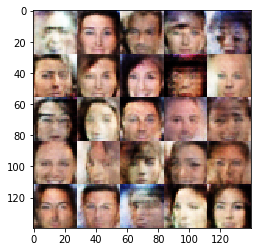

Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 0.2648
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 0.6690... Generator Loss: 1.2636
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.4263
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.3544
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 1.1162


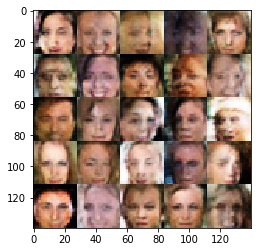

Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 2.2441
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 0.9594


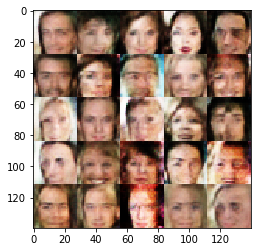

Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 1.1706
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.3483


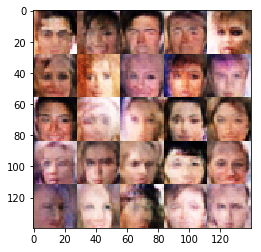

Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 1.1267
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 1.2064
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.4787
Epoch 1/1... Discriminator Loss: 1.6287... Generator Loss: 0.2913
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 1.1436
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.4030


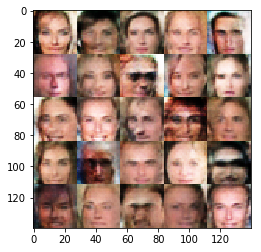

Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 1.4902
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 0.8311... Generator Loss: 1.4833
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 1.1416
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.5719


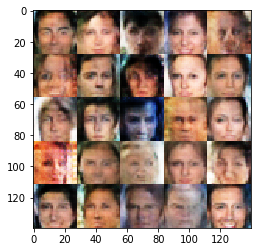

Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 0.6393... Generator Loss: 1.3898
Epoch 1/1... Discriminator Loss: 1.6412... Generator Loss: 0.2816
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.1047
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.6622


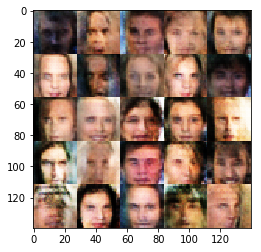

Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 1.3416
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.4191
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 0.8874... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 0.6679


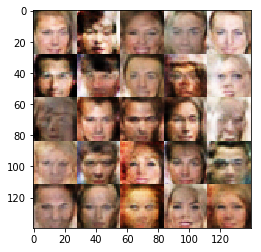

Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 1.9146
Epoch 1/1... Discriminator Loss: 1.9712... Generator Loss: 0.2056
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 1.4102
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 1.3298
Epoch 1/1... Discriminator Loss: 0.7472... Generator Loss: 1.2105


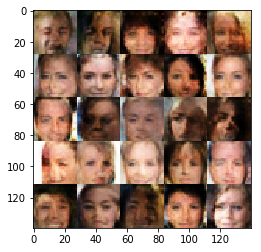

Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 1.2783
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.4727
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.4808
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.7958


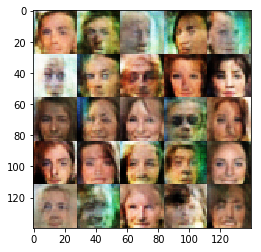

Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 1.1020
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.4505
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 2.0849
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.4198
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 1.8349


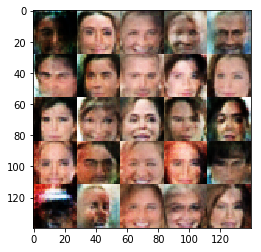

Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 1.3650
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.3603
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.9907


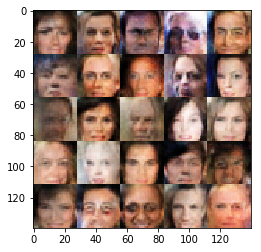

Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 2.0167
Epoch 1/1... Discriminator Loss: 2.3747... Generator Loss: 0.1245
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.4530
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.4459


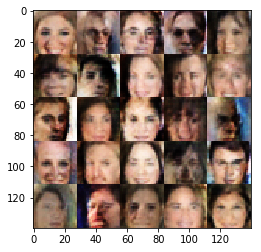

Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.4243
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 1.2652
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 1.4757


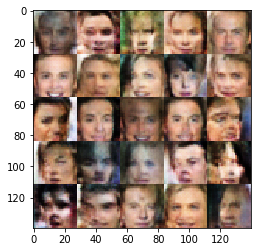

Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 1.1454
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 0.8046... Generator Loss: 1.3433
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.2345
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 0.9626


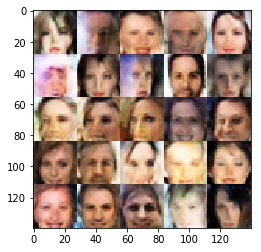

Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 1.3253
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.0527
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.4803
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 0.9029


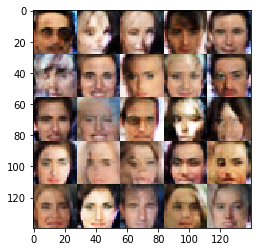

Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.4082
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.4872
Epoch 1/1... Discriminator Loss: 0.7736... Generator Loss: 1.8975
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.6915... Generator Loss: 0.3392
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.7026


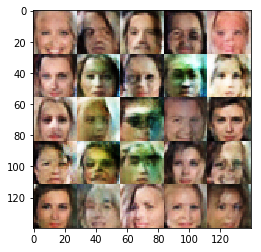

Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 0.7141... Generator Loss: 1.5699
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 1.5955
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.4139
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.7118


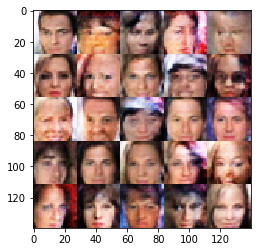

Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 1.3361
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.3486
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 0.6276... Generator Loss: 1.8223
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.6634


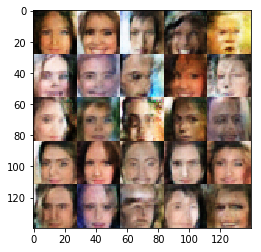

Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 1.0843
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.3719
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 0.8338... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.2074
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 0.8203


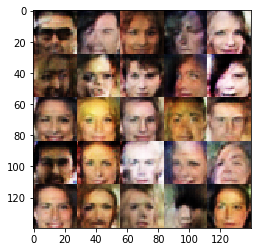

Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 0.4392... Generator Loss: 1.7540
Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 2.2655... Generator Loss: 0.1467
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7920


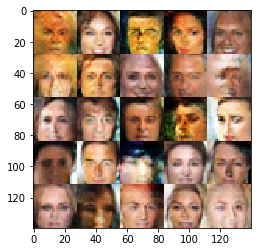

Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.5465... Generator Loss: 1.2305
Epoch 1/1... Discriminator Loss: 0.6943... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 1.3489
Epoch 1/1... Discriminator Loss: 0.7350... Generator Loss: 1.4855
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 1.3994
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.5060
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 1.3439


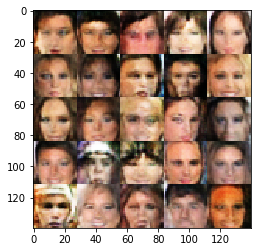

Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.4130
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 0.6813... Generator Loss: 1.3175
Epoch 1/1... Discriminator Loss: 0.6990... Generator Loss: 2.2798
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.1684
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 1.1862


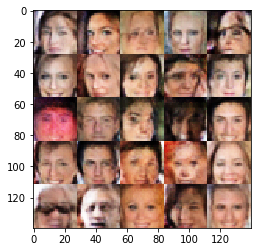

Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.2601
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.5109... Generator Loss: 0.3367
Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 0.7313... Generator Loss: 2.4176
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 1.4558
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.2668


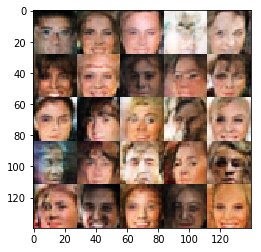

Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.4430
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 1.1705
Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.2144


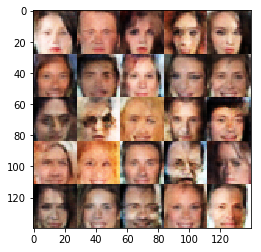

Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 1.5843
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 1.4909
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 0.2850
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.3648
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.4301
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.7518


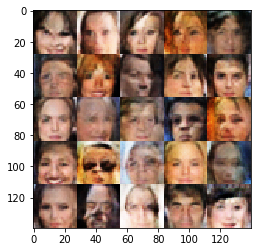

Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.2777
Epoch 1/1... Discriminator Loss: 1.8447... Generator Loss: 0.2572
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.6054
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 0.9153


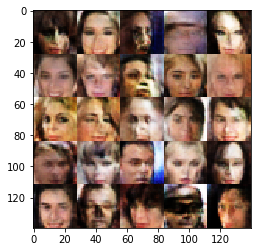

Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.4748
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 1.1321
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.5064
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 1.2991
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 0.6530


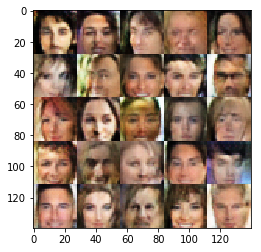

Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 1.1930
Epoch 1/1... Discriminator Loss: 2.0009... Generator Loss: 2.2261
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 1.6601
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.4466
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 0.8872


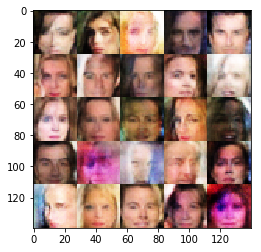

Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.4547
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.1978
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.8021


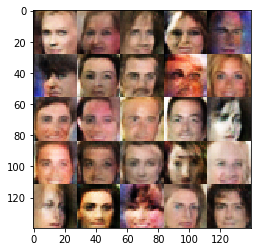

Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.4057
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 1.6082


IndexError: list index out of range

In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.